In [53]:
#Import required packages
import numpy as np
from hyperopt import hp, fmin, tpe, space_eval
from scikits.odes.ode import ode
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [54]:
#Helper functions
def loss_biological(j1, j2, alpha1=1E-5, alpha2=1E-2):
        """Computes scalarized loss including genetic constraint and product production"""
        loss = alpha1*j1 + alpha2*j2
        return j1, j2, loss

def activation(x, k, theta, n):
    return (k*(x/theta)**n)/(1+(x/theta)**n)

def repression(x, k, theta, n):
    return k/(1+(x/theta)**n)
    
def nonlinearity(x, kc, km):
    return (kc*x)/(km+x)

def name_converter(A):
    if A == ((0, 1, 0), (1, 0, 0)):
        return 'Dual Control'

    elif A == ((0, 0, 1), (0, 0, 1)):
        return 'No Control'

    elif A == ((0, 0, 1), (1, 0, 0)):
        return 'Downstream Activation'

    elif A == ((0, 1, 0), (0, 0, 1)):
        return 'Upstream Repression'
    else: return 'Invalid Circuit'


In [55]:
#Toy model with generated architecture
def toy_model(t, y, ydot, params):
    kc=12.; km=10.; lam=1.93E-4; Vin=1.; e0=0.0467
    T = 1; E = 2; X = 2
    A, W = params
    ydot[0] = Vin - lam*y[0] - e0*nonlinearity(y[0], kc, km) - y[2]*nonlinearity(y[0], kc, km)
    ydot[1] = y[2]*nonlinearity(y[0], kc, km) - y[3]*nonlinearity(y[1], kc, km) - lam*y[1]
    for e in range(E):
        ydot[e+X] = -lam*y[e+X] + np.sum(A[e]*np.array([activation(y[T], W[e][2], W[e][1], W[e][0]), repression(y[T], W[e][2], W[e][1], W[e][0]), W[e][2]]))
    ydot[E+X] = (Vin - y[X+1]*nonlinearity(y[X-1], kc, km))**2 #J1
    ydot[E+X+1] = np.sum([np.sum(A[e]*np.array([activation(y[T], W[e][2], W[e][1], W[e][0]), repression(y[T], W[e][2], W[e][1], W[e][0]), W[e][2]])) for e in range(E)]) #J2

In [56]:
#Define search space
space = hp.choice('architecture', 
    [([[0, 0, 1], [1, 0, 0]], [[2., hp.uniform('theta1_da', 0.001, 10), hp.uniform('k1_da', 1E-7, 1E-3)], [2., hp.uniform('theta2_da', 0.001, 10), hp.uniform('k2_da', 1E-7, 1E-3)]]),
     ([[0, 1, 0], [0, 0, 1]], [[2., hp.uniform('theta1_ur', 0.001, 10), hp.uniform('k1_ur', 1E-7, 1E-3)], [2., hp.uniform('theta2_ur', 0.001, 10), hp.uniform('k2_ur', 1E-7, 1E-3)]]),
     ([[0, 0, 1], [0, 0, 1]], [[2., hp.uniform('theta1_nc', 0.001, 10), hp.uniform('k1_nc', 1E-7, 1E-3)], [2., hp.uniform('theta2_nc', 0.001, 10), hp.uniform('k2_nc', 1E-7, 1E-3)]]),
     ([[0, 1, 0], [1, 0, 0]], [[2., hp.uniform('theta1_dc', 0.001, 10), hp.uniform('k1_dc', 1E-7, 1E-3)], [2., hp.uniform('theta2_dc', 0.001, 10), hp.uniform('k2_dc', 1E-7, 1E-3)]])])
    

In [148]:
def run_hyperopt(max_iters):
    losses = []
    params = []
    circuits = []

    #Define objective function
    def objective(args):
        architecture, param_values = args
        #Integration conditions
        t = np.linspace(0, 5E4, 100) 
        y0 = np.array([2290., 0., 0., 0., 0., 0.])

        extra_options = {'old_api': False, 'user_data': [architecture, param_values]}
        ode_solver = ode('cvode', toy_model, **extra_options)
        solution = ode_solver.solve(t, y0)
        j1, j2 = solution.values.y[-1, -2:]
        j1, j2, loss = loss_biological(j1, j2, alpha1=alpha1_setting, alpha2=alpha2_setting)

        losses.append(loss)
        params.append(param_values)
        circuits.append(architecture)
        return loss

    #Run hyperopt call
    best = fmin(objective, space, algo=tpe.suggest, max_evals=max_iters)
    print(space_eval(best))
    #Create trajectory data frame
    landscape = pd.DataFrame({'Circuit':circuits, 'Loss': losses, 'k1': [params[i][0][2] for i in range(len(params))], 'k2': [params[i][1][2] for i in range(len(params))], 'theta1': [params[i][0][1] for i in range(len(params))], 'theta2': [params[i][1][1] for i in range(len(params))]})
    landscape['Circuit'] = [name_converter(c) for c in landscape.Circuit]
    return landscape, best

In [58]:
global alpha1_setting, alpha2_setting

In [149]:
num_replicates = 1
max_iters = 1000
alpha1_setting = 1E-5
alpha2_setting = 1E-2

landscape = run_hyperopt(max_iters)
landscape, best = landscape


100%|██████████| 1000/1000 [01:10<00:00, 14.20trial/s, best loss: 0.06914705929015685]


TypeError: space_eval() missing 1 required positional argument: 'hp_assignment'

In [25]:
#Scan over alpha values
max_iters = 500
alpha1_setting = 1E-5
alpha2_setting = 1E-2

alpha1s = [1E-3, 1E-4, 1E-5, 1E-6]
alpha2s = [1., 0.1, 0.01, 0.001]
spaces = []
for alpha1 in alpha1s:
    for alpha2 in alpha2s:
        alpha1_setting = alpha1
        alpha2_setting = alpha2
        landscape, best = run_hyperopt(max_iters)
        spaces.append(space_eval(space, best))
        

100%|██████████| 500/500 [00:28<00:00, 17.80trial/s, best loss: 0.006499519279758003]


In [27]:
best_architectures = [spaces[i][0] for i in range(len(spaces))]
circuit_names = [name_converter(best_architectures[i]) for i in range(len(best_architectures))]

In [42]:
alpha1 = [0.001, 0.0001, 1e-05, 1e-06, 0.001, 0.0001, 1e-05, 1e-06, 0.001, 0.0001, 1e-05, 1e-06, 0.001, 0.0001, 1e-05, 1e-06]
alpha2 = [1.0, 1.0, 1.0, 1.0, 0.1,  0.1, 0.1, 0.1, 0.01, 0.01, 0.01, 0.01, 0.001, 0.001, 0.001, 0.001]
df = pd.DataFrame({'alpha1':alpha1, 'alpha2': alpha2, 'circuit':circuit_names})

In [45]:
df.replace(value_to_int)

,alpha1,alpha2,circuit
0,0.001000,1.000,0
1,0.000100,1.000,1
2,0.000010,1.000,1
3,0.000001,1.000,1
4,0.001000,0.100,1
5,0.000100,0.100,1
6,0.000010,0.100,1
7,0.000001,0.100,1
8,0.001000,0.010,1
9,0.000100,0.010,1


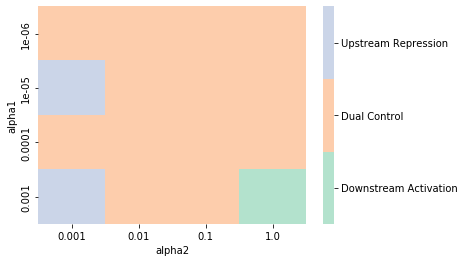

In [51]:
value_to_int = {j:i for i,j in enumerate(pd.unique(df.circuit.ravel()))} # like you did
n = len(value_to_int)     
# discrete colormap (n samples from a given cmap)
cmap = sns.color_palette("Pastel2", n) 
pivot_table = df.replace(value_to_int).pivot("alpha1", "alpha2", "circuit")
ax = sns.heatmap(pivot_table, cmap=cmap) 
# modify colorbar:
colorbar = ax.collections[0].colorbar 
r = colorbar.vmax - colorbar.vmin 
colorbar.set_ticks([colorbar.vmin + r / n * (0.5 + i) for i in range(n)])
colorbar.set_ticklabels(list(value_to_int.keys()))                                          
plt.savefig('4x4_alphascan.png')

In [31]:
replicate_landscapes.to_csv('toy_model.csv')

c:\Users\Charlotte\anaconda3\envs\sundials\lib\site-packages\seaborn\distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.4 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


(0.0, 1.2)

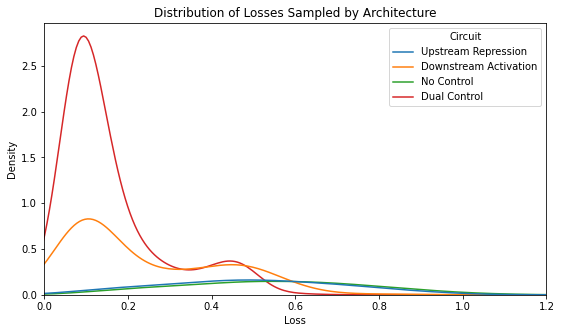

In [33]:
#Distribution of losses sampled from each architecture, 10 replicates
replicate_landscapes = replicate_landscapes.reset_index(drop=True)
fig, ax = plt.subplots(1, 1, figsize=(9, 5))
sns.kdeplot( x='Loss', hue='Circuit', data=replicate_landscapes, ax=ax, bw=0.4)
ax.set_title('Distribution of Losses Sampled by Architecture')
ax.set_xlim([0, 1.2])

Text(0.5, 0.98, 'Theta1')

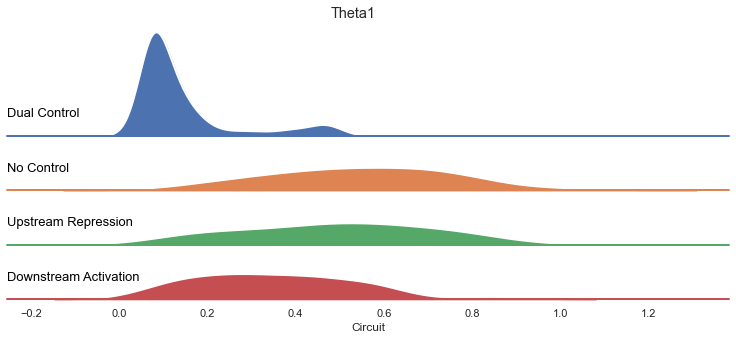

In [36]:
#Alternate plot type
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
circuits = ['Dual Control', 'No Control', 'Downstream Activation', 'Upstream Repression']
palette = sns.color_palette()
g = sns.FacetGrid(landscape, palette=palette, row="Circuit", hue="Circuit", aspect=9, height=1.2)

g.map_dataframe(sns.kdeplot, x="Loss", fill=True, alpha=1, clip_on=False)
g.map_dataframe(sns.kdeplot, x="Loss", color='white', clip_on=False, lw=2, bw_adjust=1)
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, color='black', fontsize=13,
            ha="left", va="center", transform=ax.transAxes)
    
g.map(label, "Circuit")
g.set_titles("")
g.set_ylabels("")
g.set(yticks=[])
g.despine(bottom=True, left=True)
g.fig.subplots_adjust(hspace=-.5)
g.fig.suptitle('Theta1')

In [95]:
def get_best_loss_trace(landscape):
    best_loss = 1E5
    best_circuit = 'Initial'
    best_losses = []
    best_losses_circuits = []
    for i in range(len(landscape)):
        if landscape.Loss[i] < best_loss:
            best_loss = landscape.Loss[i]
            best_circuit = landscape.Circuit[i]
        best_losses.append(best_loss)
        best_losses_circuits.append(best_circuit)
    return best_losses, best_losses_circuits

In [54]:
replicate_landscapes = pd.read_csv('toy_model.csv')
replicate_landscapes['Iterations'] = replicate_landscapes['Unnamed: 0']

In [ ]:
landscape_save = landscape

In [96]:
best_loss_landscape = pd.DataFrame(columns=['Circuit', 'Loss', 'k1', 'k2', 'theta1', 'theta2', 'Best Loss', 'Best Loss Architecture'])
start_index = 0
min_losses, min_archs = [[], []]
for i in range(num_replicates):
    #landscape = replicate_landscapes.iloc[start_index:start_index+max_iters].reset_index(drop=True)
    best_losses, best_loss_circuits = get_best_loss_trace(landscape)
    landscape['Best Loss'] = best_losses
    landscape['Best Loss Architecture'] = best_loss_circuits
    best_loss_landscape = pd.concat([best_loss_landscape, landscape])
    start_index = start_index+max_iters+1
    min_archs.append(best_loss_circuits[-1])
    min_losses.append(best_losses[-1])
best_loss_landscape = best_loss_landscape.reset_index(drop=True)

In [90]:
print('Mean best loss', np.mean(min_losses))
print('STD best loss', np.std(min_losses))
min_archs

Mean best loss 0.06330464010414799
STD best loss 0.001392693157464271


['Downstream Activation',
 'Downstream Activation',
 'Dual Control',
 'Downstream Activation',
 'Dual Control',
 'Dual Control',
 'Dual Control',
 'Dual Control',
 'Dual Control',
 'Dual Control']

(0.0, 200.0)

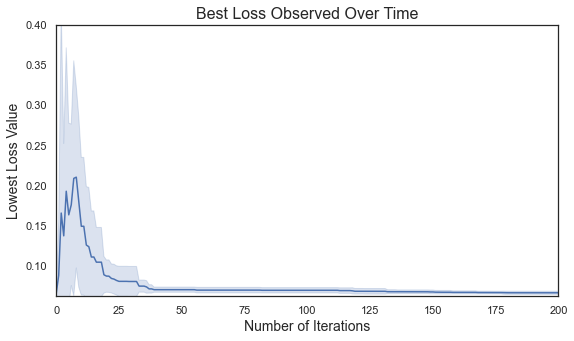

In [71]:
fig, axs = plt.subplots(1, 1, figsize=(9, 5))
endpoint = 'Best Loss Observed Over Time'

ax = axs
ax.set_title(f'{endpoint}', fontsize=16)
ax.set_ylabel('Lowest Loss Value', fontsize=14)
ax.set_xlabel('Number of Iterations', fontsize=14)
sns.lineplot(data=best_loss_landscape, x='Iterations', y='Best Loss', ci='sd', ax=ax)
#ax.set_yscale('log')
ax.set_ylim([best_loss_landscape.Loss.min(), 0.4])
ax.set_xlim([0, 200])

c:\Users\Charlotte\anaconda3\envs\sundials\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\Charlotte\anaconda3\envs\sundials\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:title={'center':'Best Loss over Iterations, Colored by Circuit'}, xlabel='Number of Iterations', ylabel='Loss Value'>

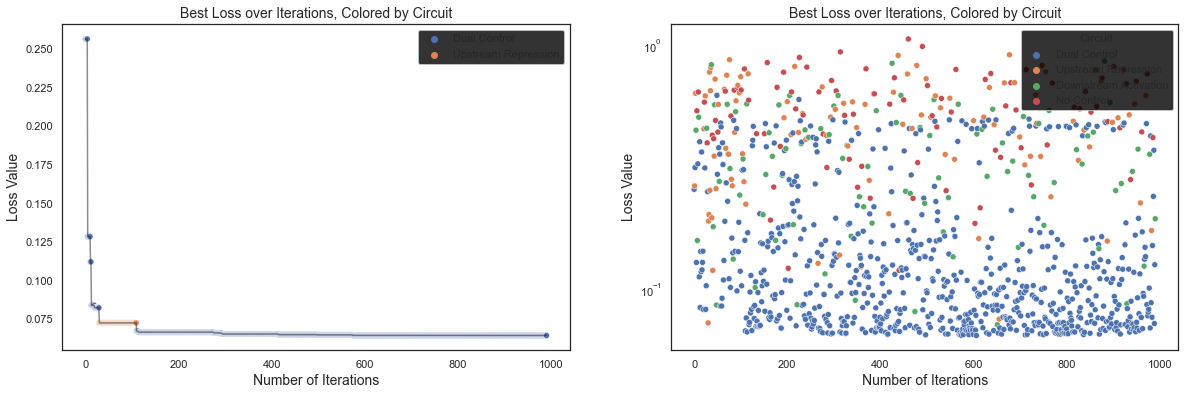

In [81]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6))
endpoint = 'Best Loss over Iterations, Colored by Circuit'

ax = axs[0]
ax.plot(best_losses, 'k-', alpha=0.5)
ax.set_title(f'{endpoint}', fontsize=14)
ax.set_ylabel('Loss Value', fontsize=14)
ax.set_xlabel('Number of Iterations', fontsize=14)
sns.scatterplot(range(len(landscape)), best_losses, hue=best_loss_circuits,  ax=ax)


ax = axs[1]
ax.set_title(f'{endpoint}', fontsize=14)
ax.set_ylabel('Loss Value', fontsize=14)
ax.set_xlabel('Number of Iterations', fontsize=14)
ax.set_yscale('log')
sns.scatterplot(range(len(landscape)), 'Loss', hue='Circuit', data=landscape, ax=ax)

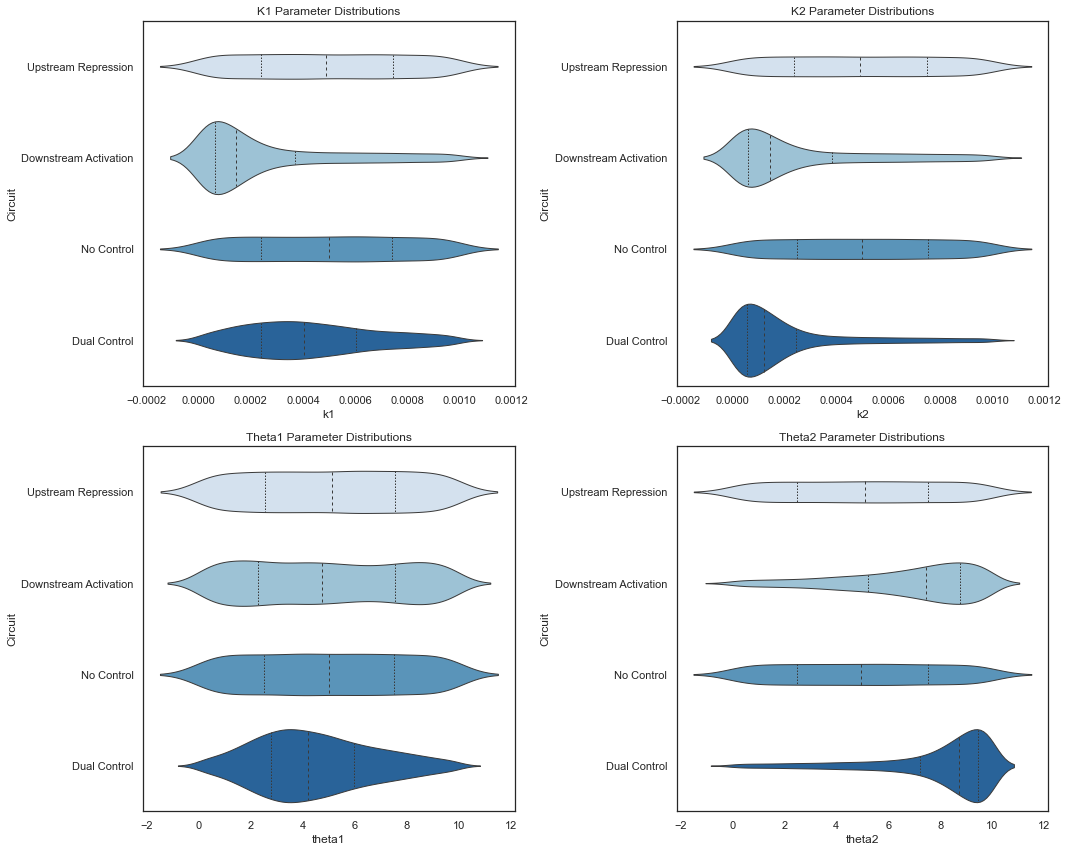

In [92]:
#Compute standard deviation/box plots
fig, axs = plt.subplots(2, 2, figsize=(15, 12))
ax = axs[0][0]
sns.violinplot(data=best_loss_landscape, x="k1", y="Circuit", inner="quart", linewidth=1, palette = 'Blues', ax=ax)
ax.set_title('K1 Parameter Distributions')

ax = axs[0][1]
sns.violinplot(data=best_loss_landscape, x="k2", y="Circuit", inner="quart", linewidth=1, palette = 'Blues', ax=ax)
ax.set_title('K2 Parameter Distributions')

ax = axs[1][0]
sns.violinplot(data=best_loss_landscape, x="theta1", y="Circuit", inner="quart", linewidth=1, palette = 'Blues', ax=ax)
ax.set_title('Theta1 Parameter Distributions')

ax = axs[1][1]
sns.violinplot(data=best_loss_landscape, x="theta2", y="Circuit",  inner="quart", linewidth=1, palette = 'Blues', ax=ax)
ax.set_title('Theta2 Parameter Distributions')

fig.tight_layout()

In [84]:
#Bar plot splitting trajectory into quintiles

orders = ['No Control', 'Upstream Repression', 'Downstream Activation', 'Dual Control']
palette = {'No Control': sns.color_palette()[3], 'Upstream Repression': 'tab:orange', 'Downstream Activation': 'tab:green', 'Dual Control': 'tab:blue', 'Initial':'black'}



quantiles10 = np.array_split(landscape, 5)
dc = []
da = []
nc = []
ur = []
for i in range(5):
    nums = quantiles10[i].groupby('Circuit').count().Loss
    percents = 100*nums/(len(landscape)/5)
    dc.append(percents['Dual Control'])
    da.append(percents['Dual Control']+percents['Downstream Activation'])
    ur.append(percents['Dual Control']+percents['Downstream Activation']+percents['Upstream Repression'])
    nc.append(percents['Dual Control']+percents['Downstream Activation']+percents['Upstream Repression']+percents['No Control'])
data = pd.DataFrame({'Quintile': range(1,6), 'Downstream Activation': da, 'Dual Control': dc, 'Upstream Repression': ur, 'No Control': nc})


#plt.savefig('Gamma90_barplot.png')

Text(0.5, 0, 'Epoch Quintile')

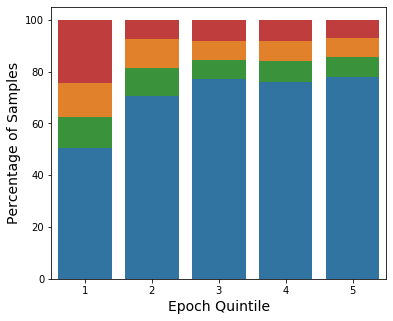

<Figure size 648x360 with 0 Axes>

In [87]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
plt.figure(figsize=(9, 5))
bar4 = sns.barplot(x="Quintile",  y="No Control", data=data, color=palette['No Control'], ax=ax)
bar3 = sns.barplot(x="Quintile",  y="Upstream Repression", data=data, color=palette['Upstream Repression'], ax=ax)
bar2 = sns.barplot(x="Quintile",  y="Downstream Activation", data=data, color=palette['Downstream Activation'], ax=ax)
bar1 = sns.barplot(x="Quintile",  y="Dual Control", data=data, color=palette['Dual Control'], ax=ax)
ax.set_ylabel('Percentage of Samples', fontsize=14)
ax.set_xlabel('Epoch Quintile', fontsize=14)

Text(0.5, 0, 'Number of Iterations')

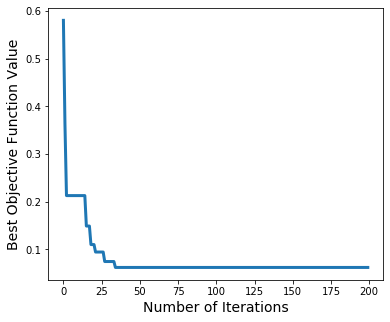

In [101]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
ax.plot(best_loss_landscape['Best Loss'][:200], linewidth=3)
ax.set_ylabel('Best Objective Function Value', fontsize=14)
ax.set_xlabel('Number of Iterations', fontsize=14)

/Users/charlotte/opt/anaconda3/envs/sundials/lib/python3.9/site-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.4 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


(0, 1.2)

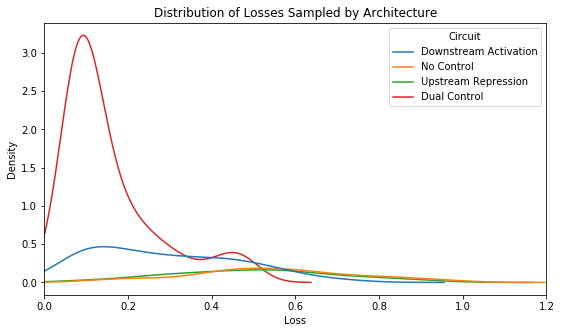

In [103]:
#Distribution of losses sampled from each architecture, 10 replicates
fig, ax = plt.subplots(1, 1, figsize=(9, 5))
sns.kdeplot( x='Loss', hue='Circuit', data=best_loss_landscape, ax=ax, bw=0.4)
ax.set_title('Distribution of Losses Sampled by Architecture')
ax.set_xlim([0, 1.2])

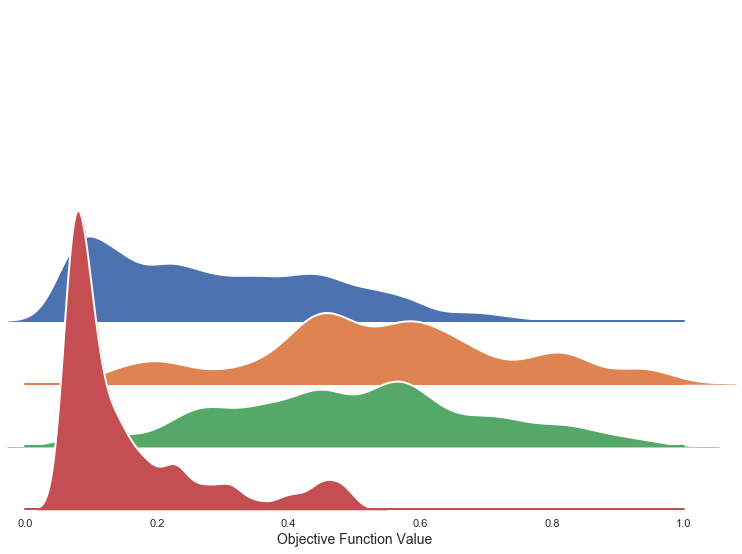

In [144]:
#Alternate plot type
circuits = ['Dual Control', 'No Control', 'Downstream Activation', 'Upstream Repression']
palette = sns.color_palette()
g = sns.FacetGrid(best_loss_landscape, palette=palette, row="Circuit", hue="Circuit", aspect=5, height=2)

g.map_dataframe(sns.kdeplot, x="Loss", fill=True, alpha=1, clip_on=False, bw_adjust=0.5)
g.map_dataframe(sns.kdeplot, x="Loss", color='white', clip_on=False, lw=2, bw_adjust=0.5)
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


def label(x, color, label):
    ax = plt.gca()
    ax.text(-0.2, 0.05, label, color='black', fontsize=13,
            ha="left", va="center", transform=ax.transAxes)
    
#g.map(label, "Circuit")
g.set_titles("")
g.set_ylabels("")
g.set_xlabels('Objective Function Value', fontsize=14)
g.set(yticks=[], xlim=[0, 1])
g.despine(bottom=True, left=True)
g.fig.subplots_adjust(hspace=-.8)

In [138]:
best_loss_landscape.best_loss_landscape.Loss.min()

0.06173021103571423

In [145]:
best

{'architecture': 0,
 'k1_da': 5.216987799210861e-05,
 'k2_da': 3.549478161774566e-05,
 'theta1_da': 4.853207730108551,
 'theta2_da': 8.22539259653745}

In [147]:
best

{'architecture': 0,
 'k1_da': 5.216987799210861e-05,
 'k2_da': 3.549478161774566e-05,
 'theta1_da': 4.853207730108551,
 'theta2_da': 8.22539259653745}